# Auditing Allocative Bias

In this blog post, we are going to train a machine learning model to predict whether an individual in the state of New Jersey (NJ) has an income of over $50K based on demographic characteristics, excluding sex. After training this model, we will perform a fairness audit to assess whether or not our model displays bias with respect to sex. 

## Preparing the data

We first download the PUMS data for the state of New Jersey and add a column to indicate whether the individual makes more than \$50K. This new column is titled `SAL50K` and has the value `1` if the individual makes \$50K or more and `0` otherwise. 

In [1]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "NJ"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

# Download PUMS data for NEW JERSEY 
acs_data = data_source.get_data(states=[STATE], download=True)

# Add column to indicate whether individual makes more than 50K 
acs_data = acs_data.assign(SAL50K = 1 * (acs_data['PINCP'] >= 50000))

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80,SAL50K
0,P,2018GQ0000003,2,1,2302,1,34,1013097,12,23,...,3,12,2,3,14,12,13,12,2,0
1,P,2018GQ0000017,2,1,1800,1,34,1013097,11,51,...,2,9,9,19,10,19,19,2,10,0
2,P,2018GQ0000122,2,1,2104,1,34,1013097,24,69,...,22,45,2,3,24,24,23,44,1,0
3,P,2018GQ0000131,2,1,800,1,34,1013097,90,18,...,96,158,96,14,145,157,15,88,156,0
4,P,2018GQ0000134,2,1,1700,1,34,1013097,68,89,...,67,68,69,6,123,131,132,127,68,0


Based on the dimensions of our downloaded PUMS data, we see that there are over 250 features documented. These are too many features to train on, so in our modeling tasks, we will only focus on ...  

- `AGEP` is age  
- `SCHL` is educational attainment  
- `MAR` is marital status  
- `RELP` is relationship  
- `CIT` is citizenship status. 
- `MIG` is mobility status
- `MIL` is miliary service
- `ANC` is ancestry recode
- `RAC1P` is race *(1 for White Alone, 2 for Black/African American alone, 3 for Native American alone, 4 for Alaska Native alone, 5 for Native American and Alaska Native tribes specified, 6 for Asian alone, 7 for Native Hawaiian and Other Pacific Islander alone, 8 for Some Other Race alone, 9 for Two or more races)*  
- `ESR` is employment status *(1 if employed, 0 if not)*  
- `DIS`, `DEAR`, `DEYE`, and `DREM` relate to certain disability statuses  

Note that we do not include ...  

- `SEX` is binary sex (1 for male, 2 for female)  
- `SAL50K` is added column indicating whether the individual makes more than 50K  

for `SEX` is our group choice that we will evaluate bias against and `SAL50K` is our target variable. 

In [2]:
# Possible features suggested to use
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR', 'SAL50K']

# Subset features want to use
features_to_use = [f for f in possible_features if f not in ["SEX", "PINCP", "SAL50K"]]

acs_data[features_to_use].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,RAC1P,ESR
0,23,21.0,5,17,2,NaN,5,2.0,4.0,1,2,2,2,2.0,6,6.0
1,51,20.0,4,17,2,NaN,4,1.0,4.0,1,2,2,2,2.0,1,1.0
2,69,19.0,3,16,1,NaN,1,1.0,4.0,4,1,2,2,2.0,1,6.0
3,18,16.0,5,16,1,NaN,1,1.0,4.0,2,1,2,2,1.0,9,6.0
4,89,19.0,2,16,1,NaN,1,1.0,4.0,4,1,2,2,1.0,1,6.0


  
Now that we have chosen our features to use, we construct a `BasicProblem` that allows us to use these features to predict whether an individual makes more than \$50K using the `SEX` as the group label. Doing this gives us our feature matrix `features`, our label vector `label`, and group label vector `group`. 

In [3]:
PaymentProblem = BasicProblem(
    features=features_to_use,
    target='SAL50K',
    target_transform=lambda x: x == 1,
    group='SEX',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = PaymentProblem.df_to_numpy(acs_data)

Finally, we perform a train-test split on the data. 

In [4]:
# Train/test split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

## Basic Descriptive of Training Data

Before we train our model, we are going to inspect any patterns we see in our training data.

In [5]:
import pandas as pd

df = pd.DataFrame(X_train, columns = features_to_use)
df["SEX"] = group_train
df[">50K"] = y_train

df.shape

(70868, 18)

Based on the dimensions of our `df` data frame, which holds all the feature values for every individual in our training data, we see that our training data has information for about 70868 different individuals. 

Based on the table below, we see that only about 31.21% of the individuals in our training data make more than $50K. 

In [6]:
more_than_50K = df.groupby([">50K"]).size().reset_index(name='count')

more_than_50K['percent'] = (more_than_50K['count'] / len(df.index) * 100).round(2)

more_than_50K = more_than_50K.style.set_caption("Income Greater Than $50K")
more_than_50K = more_than_50K.hide(axis="index")

more_than_50K

>50K,count,percent
False,48752,68.790000
True,22116,31.210000


Based on the table below, we see that of those who make more than $50K in our training data, about 59% of them are male while the remaining 41% of them are female. 

In [7]:
filtered_df = df[df['>50K'] == True]

more_than_50K_by_sex = filtered_df.groupby(['SEX']).size().reset_index(name='count')

more_than_50K_by_sex['percent'] = (more_than_50K_by_sex['count'] / len(filtered_df.index) * 100).round(2)

more_than_50K_by_sex = more_than_50K_by_sex.style.set_caption("Sex of Those with Income Greater Than $50K")
more_than_50K_by_sex.hide(axis="index")
more_than_50K_by_sex

SEX,count,percent
1,13035,58.940000
2,9081,41.060000


Based on the two tables below, we see that about 38% of males and 25% of females have an income of more than \$50K. 

In [8]:
filtered_df = df[df['SEX'] == 1]

males = filtered_df.groupby(['>50K']).size().reset_index(name='count')
males['percent'] = (males['count'] / len(filtered_df.index) * 100).round(2)
males = males.style.set_caption("Males with Income Greater Than $50K")
males.hide(axis="index")
males

>50K,count,percent
False,21342,62.080000
True,13035,37.920000


In [9]:
filtered_df = df[df['SEX'] == 2]

females = filtered_df.groupby(['>50K']).size().reset_index(name='count')
females['percent'] = (females['count'] / len(filtered_df.index) * 100).round(2)
females = females.style.set_caption("Females with Income Greater Than $50K")
females.hide(axis="index")
females

>50K,count,percent
False,27410,75.110000
True,9081,24.890000


Overall, based on these tables it looks like males are more likely to make more than $50K.  

We can also inspect intersectional trends by studying the proportion of those who make more than $50K broken out by both our chosen group labels of `SEX` and an additional group label. Here we have chosen to use `RAC1P`.  

We first create a data frame that holds that information and then use `seaborn` package to visualize the new data frame. 

Remember that ...  

- `RAC1P` is race *(1 for White Alone, 2 for Black/African American alone, 3 for Native American alone, 4 for Alaska Native alone, 5 for Native American and Alaska Native tribes specified, 6 for Asian alone, 7 for Native Hawaiian and Other Pacific Islander alone, 8 for Some Other Race alone, 9 for Two or more races)*  
- `SEX` is binary sex (1 for male, 2 for female)  

[Text(0.5, 1.0, 'Percent with Income >$50 by SEX and RAC1P')]

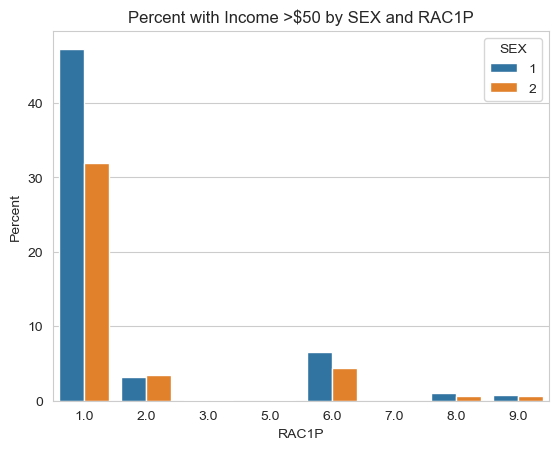

In [25]:
import seaborn as sns

# Create new dataframe
filtered_df = df[df['>50K'] == 1]
intersectionality = filtered_df.groupby(['SEX', 'RAC1P']).size().reset_index(name='count')
intersectionality['Percent'] = (intersectionality['count'] / len(filtered_df.index) * 100).round(2)

# Visualize it using seaborn package
sns.set_style("whitegrid")
sns.barplot(x="RAC1P", y="Percent", hue="SEX", data=intersectionality).set(title='Percent with Income >$50 by SEX and RAC1P')

Based on the bar plot above, we see that white men make up the majority of those who make more than \$50K in our data, followed by white women. In our training data, we also see that individuals who are not white, regardless of their sex, make up a small portion of those who make more than \$50K.

## Training Our Model

Now it is time to train our model. The model we chose to use is the `DecisionTreeClassifier`, which requires a specified `max_depth`. To find our optimum `max_depth` we use cross validation. 

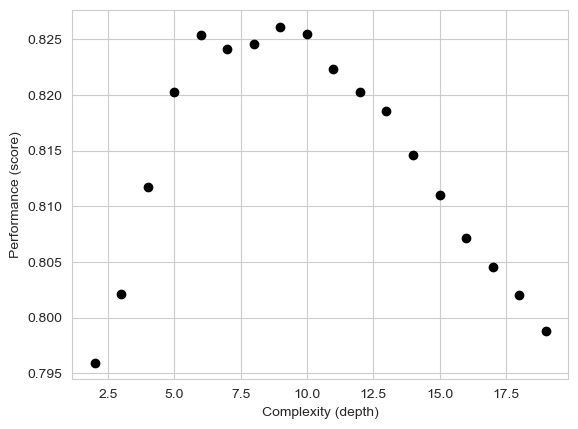

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1)

max_score = 0
best_depth = 0
for d in range(2, 20):
    T = DecisionTreeClassifier(max_depth = d)
    cv_mean = cross_val_score(T, X_train, y_train, cv = 10).mean()
    ax.scatter(d, cv_mean, color = "black")
    if cv_mean > max_score:
        max_score = cv_mean 
        best_depth = d

labs = ax.set(xlabel = "Complexity (depth)", ylabel = "Performance (score)")

For our model, we create a pipeline with `StandardScaler()` and our `DecisionTreeClassifier` with the our found optimum `max_depth`. 

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

DTC = DecisionTreeClassifier(max_depth = best_depth)
model = make_pipeline(StandardScaler(), DTC)

model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=9))])

## Auditing Our Model

Now that our model is trained, we can audit how it does on the test data. We first define a function that may help with finding the positive predictive values (PPV), which is the proportion of positive results that are truly positive, the false negative rate (FNR), and false positive rate (FPR). We also extract our predictions `y_hat` on the test data. 

In [13]:
from sklearn.metrics import confusion_matrix

def find_PPV_FNR_FPR(data, predictions):
    confusion = confusion_matrix(data, predictions)
    TP = confusion[1][1]
    TN = confusion[0][0]
    FP = confusion[0][1]
    FN = confusion[1][0]
    PPV = TP / (TP + FP)
    print(f"{PPV=}")
    FNR = FN / (FN + TP)
    print(f"{FNR=}")
    FPR = FP / (FP + TN)
    print(f"{FPR=}")

# Extract predictions 
y_hat = model.predict(X_test)

### Overall Measures

Now we can examine the overall accuracy, PPV, FNR, and FPR from our model on our test data. 

In [14]:
# Overall accuracy 
(y_hat == y_test).mean()

0.8212552206795349

In [15]:
find_PPV_FNR_FPR(y_test, y_hat)

PPV=0.7013009243409791
FNR=0.2576553723500634
FPR=0.1430445118452332


### Group Measures  

We can also examine the accuracy, PPV, FNR, and FPR for each subgroup in our test data. So examining group 1, is equivalent to examining these values for the males in the test data. And exmaining group 2, is equivalent to examining these values for the females in the test data. 

In [16]:
# Accuracy for men
(y_hat == y_test)[group_test == 1].mean()

0.8261021693491952

In [17]:
# Accuracy for women 
(y_hat == y_test)[group_test == 2].mean()

0.8167104111986002

In [20]:
#PPV FNR and FPR for male
find_PPV_FNR_FPR(y_test[group_test == 1], y_hat[group_test == 1])

PPV=0.785831960461285
FNR=0.2606943583384997
FPR=0.12154076290201944


In [21]:
#PPV FNR and FPR for female
find_PPV_FNR_FPR(y_test[group_test == 2], y_hat[group_test == 2])

PPV=0.6099038118988244
FNR=0.2533798517226341
FPR=0.15983068165231354


We see that the accuracy of each group seem to be within a reasonable range of each other, but the PPV, FNR, and FPR differ slightly. 

## Bias Measures  

Based on our work above and using the definition that calibration is where the PPV is the same for all groups in the data, it does not look like our model is calibrated. We see the males had a higher proportion of positively classified cases that were truly positive than the females.  

Based on the definition that error rate balance is where the FPR and FNR are the same for all groups, we see that our model does not have error rate balance. We see that FNR (predicting a negative label when it was actually positive) for males are slightly higher than the FNR for females. We also see that the FPR (predicting a positive label when it was actually negative) for males are lower than the FPR for females. Our model does not make the same mistakes for each group at the same rate. This is very interesting results based our basic descriptive of our training data where we found that females were a smaller proportion of those who made more than $50K. 

Based on the definition that statistical parity is where the PPVs are similar, we also see that our model does not satisfy statistical parity. 


## Conclusion  

Ultimately, we feel that our model would not be fit to be deployed in the real world.  

A model like this, that predicts income labels, might be beneficial to companies that try to function in conditions where income is not explicitly disclosed, but is useful. Companies might use a model like this to be more strategic with who to advertise towards. If the brand is known for being more expensive, they might aim to advertise more towards those who have a higher income. A model like this may also be used in more serious conditions that can greatly affect someone's way of living. Companies that aim to assist lower income individuals may use this model to predict whether who is most in need of their help. It might also help determine who qualifies for loans, insurance, or credit cards. 

Based on our bias audit, our model seems to display all types of problematic bias. Because our model is not callibrated, the rates at which positively classified cases that are truly positive are not the same for each sex. More specifically, we see the males had a higher proportion of positively classified cases that were truly positive than the females. Because our model does not have error rate balance, it does not make the same mistakes for each group at the same rate. More specifically, we see that the rate for predicting a negative label when it was actually positive for males are slightly higher than the rate for females. We also see that the rate for predicting a positive label when it was actually negative for males are lower than the rate for females.

Due to the results of our bias audit, our model could negatively impact males and females depending on the context in which it may be applied to larger scale predictions in commercial and governmental settings. For government programs that look to assist lower income individuals, this model may incorrectly predict that females make more than they do, denying them the help they might really need. For loans, insurance, or credit cards, the model might predict that males make lower than they actually do, denying them these services that can make a difference in their life. We would not be comfortable releasing these models until the results of the bias audit are improved. 

Beyond bias, I think that this model may be making decisions about an individual without taking their full picture into account. When a model like this has to make big decisions related to loans, credit cards, insurance or government assistance, I think that there should be another person overlooking the models decisions to help regulate and assess the bias in the model. I also think that the individuals this model may be evaluating should have a say before their a decision is made on their behalf. For example, if an individual is applying to a government program for assistance, they should be able to talk with those who make decisions to share more information about their story and better inform why they may need assistance. Ultimately, I think that it's still important to incorporate people into these decision making processes. 